# **Baseline Model** 
***
Establish a reproducible **TF‑IDF + Logistic Regression** benchmark for Twitter‑airline sentiment.

* **Text column** → `clean_text`  
* **Target label** → `airline_sentiment` (`negative`, `neutral`, `positive`)  
* Train / validation / test = 70 / 15 / 15 (stratified)  
* Persist artefacts to `models/`

## Notebook Outline 
1. [Load Processed Data & Train-Test Split](#1-load-processed-data--train-test-split)  
2. [Majority-class reference](#2-majority-class-reference)  
3. [TF-IDF + Logistic Regression pipeline](#3-tf-idf--logistic-regression-pipeline)  
4. [Validation performance](#4-validation-performance)  
5. [5-fold stratified CV on *all* data](#5-5-fold-stratified-cv-on-all-data)  
6. [Persisted Artifacts](#6-persisted-artifacts)  
7. [Key Takeaway](#7-key-takeaway)

In [ ]:
# Imports
from __future__ import annotations

import json
from pathlib import Path
import matplotlib.pyplot as plt

import joblib
import pandas as pd
from sklearn.model_selection import (
    train_test_split,
    cross_val_score,
    StratifiedKFold,
)
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report,
    ConfusionMatrixDisplay,
    accuracy_score,
    f1_score
)

# Detect project root (folder that contains "data/")
ROOT_DIR = Path.cwd().parent  

# Define core directories
DATA_DIR      = ROOT_DIR / "data"
PROC_DATA_DIR = DATA_DIR / "processed"
MODELS_DIR    = ROOT_DIR / "models"
REPORT_DIR    = ROOT_DIR / "reports" / "figs_04"

MODELS_DIR.mkdir(exist_ok=True)
REPORT_DIR.mkdir(parents=True, exist_ok=True)

# Locate tweets.parquet (processed > raw fallback)
PARQUET_PATH = (
    PROC_DATA_DIR / "tweets.parquet"
    if (PROC_DATA_DIR / "tweets.parquet").exists()
    else DATA_DIR / "tweets.parquet"
)
assert PARQUET_PATH.exists(), f"Missing parquet at {PARQUET_PATH}"

print(f"Project root  : {ROOT_DIR}")
print(f"Parquet source : {PARQUET_PATH.relative_to(ROOT_DIR)}")


Project root  : C:\Projects\twitter-airline-analysis
Parquet source : data\processed\tweets.parquet


# 1.  Load Processed Data & Train-Test Split
***
We keep raw string labels (`airline_sentiment`); scikit-learn encodes them internally.

In [ ]:
df = pd.read_parquet(PARQUET_PATH)

# Assert expected columns are present
required_cols = {"clean_text", "airline_sentiment"}
missing = required_cols - set(df.columns)
assert not missing, f"Missing columns: {missing}"

# Sanity: no nulls in features / target
assert df.clean_text.isna().sum() == 0
assert df.airline_sentiment.isna().sum() == 0

# Train / valid / test = 70 / 15 / 15
X_train, X_temp, y_train, y_temp = train_test_split(
    df.clean_text,
    df.airline_sentiment,
    test_size=0.30,
    stratify=df.airline_sentiment,
    random_state=42,
)
X_valid, X_test, y_valid, y_test = train_test_split(
    X_temp,
    y_temp,
    test_size=0.50,
    stratify=y_temp,
    random_state=42,
)

print(
    f"Splits → train:{len(X_train)}  valid:{len(X_valid)}  test:{len(X_test)}"
)

Splits → train:10248  valid:2196  test:2196


# 2.  Majority‑class reference
***
> **Majority‑class accuracy: 0.627**  
> (Always predicting *negative* is correct 62.7 % of the time.)

In [4]:
majority_acc = y_train.value_counts(normalize=True).max()
print(f"Majority‑class accuracy: {majority_acc:.3f}")

Majority‑class accuracy: 0.627


# 3. TF‑IDF + Logistic Regression pipeline
***
Bi‑gram coverage, minimal regularisation tuning, and `class_weight='balanced'` to counter the 63 % negative skew.

In [5]:
pipe_lr = Pipeline(
    [
        (
            "tfidf",
            TfidfVectorizer(
                ngram_range=(1, 2),
                min_df=2,
                max_features=50_000,
            ),
        ),
        (
            "clf",
            LogisticRegression(
                max_iter=2_000,
                n_jobs=-1,
                class_weight="balanced",
            ),
        ),
    ]
)

pipe_lr.fit(X_train, y_train)

,steps,"[('tfidf', ...), ('clf', ...)]"
,transform_input,None
,memory,None
,verbose,False
,input,'content'
,encoding,'utf-8'
,decode_error,'strict'
,strip_accents,None
,lowercase,True
,preprocessor,None
,tokenizer,None


# 4. Validation performance
***

| Metric | Score |
| ------ | ----- |
| **Accuracy** | **0.788** |
| **Macro F1** | **0.741** |
| Weighted F1 | 0.792 |

The model is strongest on the *negative* class (precision ≈ 0.89) and weakest on *neutral*—an expected pattern given the class imbalance.

In [6]:
print(
    classification_report(
        y_valid,
        pipe_lr.predict(X_valid),
        digits=3,
        target_names=["neg", "neu", "pos"],
    )
)

              precision    recall  f1-score   support

         neg      0.888     0.836     0.862      1376
         neu      0.590     0.703     0.642       465
         pos      0.728     0.710     0.719       355

    accuracy                          0.788      2196
   macro avg      0.736     0.750     0.741      2196
weighted avg      0.799     0.788     0.792      2196



# 5. 5‑fold stratified CV on *all* data
***

**Cross-Validated Macro F1:** **0.749 ± 0.007**

The low standard deviation indicates the baseline is stable across folds.

In [7]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

cv_scores = cross_val_score(
    pipe_lr,
    df.clean_text,
    df.airline_sentiment,
    cv=cv,
    scoring="f1_macro",
    n_jobs=-1,
)

print(f"CV F1_macro = {cv_scores.mean():.3f} ± {cv_scores.std():.3f}")

CV F1_macro = 0.749 ± 0.007


## Held-Out Test Set Confusion Matrix

The confusion matrix visually confirms the model's strengths and areas for improvement:

- **Negative Class:** Excellent recall and precision.
- **Neutral Class:** Frequent confusion with both *negative* and *positive* classes indicates difficulty capturing neutrality.

*(Matrix figure saved as `reports/figs_04/conf_matrix.png`.)*

,precision,recall,f1-score
negative,0.889,0.840,0.864
neutral,0.595,0.686,0.637
positive,0.709,0.718,0.713
weighted,0.798,0.788,0.792



Overall: {'accuracy': 0.788, 'weighted‑F1': 0.792}


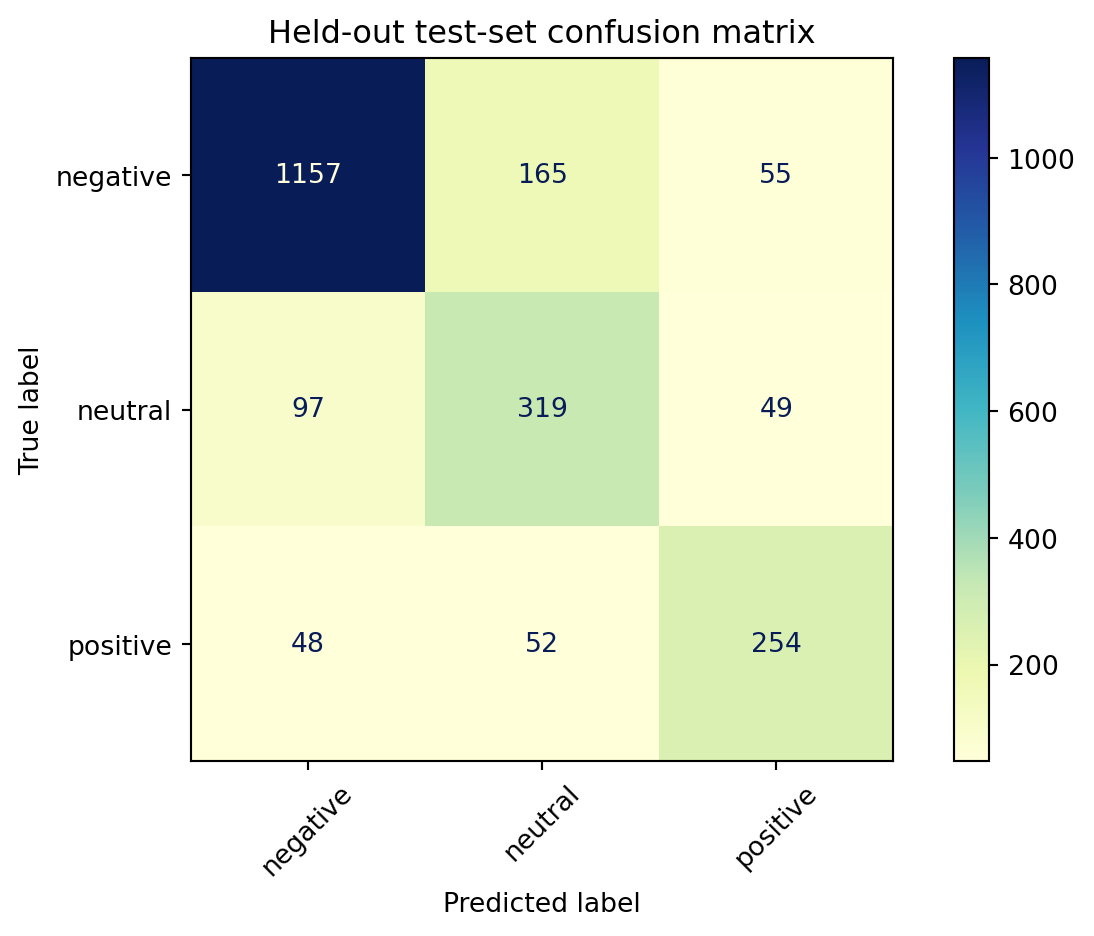

In [ ]:
# Held‑out predictions  
y_pred = pipe_lr.predict(X_test)   # X_test comes from the earlier split cell

report_dict = classification_report(
    y_test, y_pred,
    target_names=["negative", "neutral", "positive"],
    output_dict=True,
    zero_division=0       
)

# tidy DataFrame, keep only precision/recall/f1
metrics_df = (
    pd.DataFrame(report_dict)
      .T                                   # classes as rows
      .loc[["negative", "neutral", "positive", "weighted avg"],  # row order
           ["precision", "recall", "f1-score"]]
      .rename(index={"weighted avg": "weighted"})                # shorter name
      .round(3)
)

display(metrics_df)

overall = pd.Series({
    "accuracy":      accuracy_score(y_test, y_pred),
    "weighted‑F1":   f1_score(y_test, y_pred, average="weighted")
}).round(3)

print("\nOverall:", overall.to_dict())

disp = ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred,
    labels=["negative", "neutral", "positive"],
    cmap="YlGnBu", xticks_rotation=45, colorbar=True
)

plt.title("Held‑out test‑set confusion matrix")
plt.tight_layout()
plt.savefig(REPORT_DIR / "conf_matrix.png", dpi=150)
plt.show()                  


# 6. Persisted Artifacts
***

- **Model:** `models/logreg_tfidf.joblib`  
- **Cross-Validation Scores:** `models/cv_logreg.json`


In [9]:
MODEL_PATH = MODELS_DIR / "logreg_tfidf.joblib"
CV_PATH    = MODELS_DIR / "cv_logreg.json"

joblib.dump(pipe_lr, MODEL_PATH)
print(f"Saved model → {MODEL_PATH.relative_to(ROOT_DIR)}")

with CV_PATH.open("w") as fp:
    json.dump({"f1_macro": cv_scores.tolist()}, fp, indent=2)
print(f"Saved CV scores → {CV_PATH.relative_to(ROOT_DIR)}")

Saved model → models\logreg_tfidf.joblib
Saved CV scores → models\cv_logreg.json


# 7. Key Takeaway
***

* Baseline (majority class) caps out at **62.7 %** accuracy.  
* TF‑IDF + Logistic Regression lifts validation accuracy to **78.8 %** and macro F1 to **0.74**.  
* 5‑fold CV confirms robustness (**0.749 ± 0.007** macro F1).  
* Confusion matrix shows excellent precision for the *negative* class but persistent confusion between *neutral* and both extremes.  
* With class‑weight balancing and bigram coverage, a classical model already delivers a +16 pp accuracy gain over the baseline.